# Convolution
- Classification de sentiments

    

In [7]:
import logging
import torchtext.datasets as datasets
import torchtext.data as data
import torchtext
import torch.nn as nn
import torch.nn.functional as F

import nltk
import torch

import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import pandas as pd

from spacy.lang.en.stop_words import STOP_WORDS

MODEL_PATH = 'models/parallel_text_clf'

In [2]:
DATA_DIR="/home/samutamm/Documents/Study/Sorbonne/AS/TME/data"

DATASET_DIR="%s/data" % DATA_DIR
VECTORS_DIR="%s/vectors" % DATA_DIR

torch.cuda.set_device(0)
device = torch.device('cuda')

# text
TEXT=data.Field(lower=True,include_lengths=False,batch_first=True)# stop_words=list(STOP_WORDS))
LABEL = data.Field(sequential=False, is_target=True)

# make splits for data
train, val, test = datasets.sst.SST.splits(TEXT, LABEL,root=DATASET_DIR)

# Use the vocabulary
wordemb = torchtext.vocab.GloVe("6B", dim=100, cache=VECTORS_DIR)
# Build the vocabularies
# for labels, we use special_first to False so <unk> is last
# (to discard it)
TEXT.build_vocab(train, vectors=wordemb)
LABEL.build_vocab(train, specials_first=False)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
(train, val, test), batch_size=10, device=device)

nn_embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors).to(device=device)

### Visualize dataset content

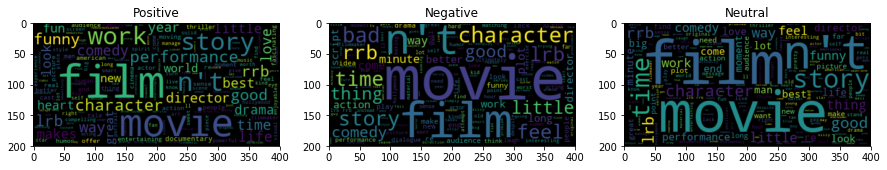

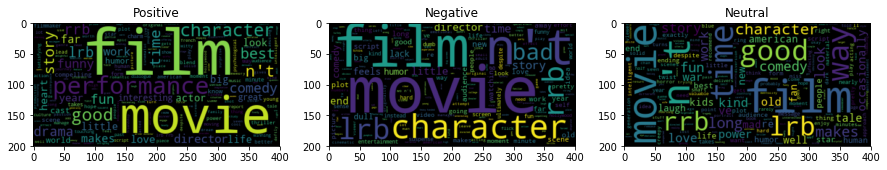

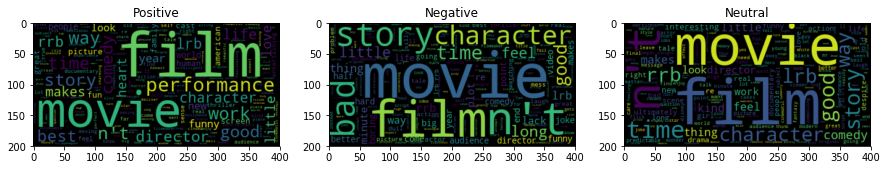

In [149]:
def visualize_dataset(iterable):
    pos_text = " ".join(np.concatenate([ex.text for ex in iterable.examples if ex.label == 'positive']))
    neg_text = " ".join(np.concatenate([ex.text for ex in iterable.examples if ex.label == 'negative']))
    ntr_text = " ".join(np.concatenate([ex.text for ex in iterable.examples if ex.label == 'neutral']))
    pos_wordcloud = WordCloud().generate(pos_text)
    neg_wordcloud = WordCloud().generate(neg_text)
    ntr_wordcloud = WordCloud().generate(ntr_text)
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(131)
    ax.set_title("Positive")
    ax.imshow(pos_wordcloud, interpolation='bilinear')
    ax1 = f.add_subplot(132)
    ax1.imshow(neg_wordcloud, interpolation='bilinear')
    ax1.set_title("Negative")
    ax2 = f.add_subplot(133)
    ax2.imshow(ntr_wordcloud, interpolation='bilinear')
    ax2.set_title("Neutral")
    plt.show()
    
visualize_dataset(train)
visualize_dataset(val)
visualize_dataset(test)

Il sont des revues des films. Parmis les mots les plus populaires, c'est difficile de dire si un revue est positif ou negatif.

## Build model

In [3]:
class SentimentConv(nn.Module):
    """
    """

    def __init__(self, 
                 filter_N=64, 
                 kernels = [3,4], 
                 dropout_ratio=0.5, 
                 embedding_dim = 100, 
                 outputs=2):
        super().__init__()
        
        self.convs = nn.ModuleList(
            [nn.Conv2d(in_channels=1,out_channels=filter_N,kernel_size=(k, embedding_dim)) for k in kernels]
        )
        self.dropout = nn.Dropout(dropout_ratio)
        self.classifier = nn.Sequential(
            nn.Linear(filter_N * len(kernels), outputs)
        )

    def forward(self, input):
        
        conveds = [torch.relu(conv(input.unsqueeze(1)).squeeze(3)) for conv in self.convs]
        pooleds = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conveds]
        
        output = self.dropout(torch.cat(pooleds, dim=1))
        output = self.classifier(output)
        return output

In [5]:
def accuracy(output, target):
    #import pdb; pdb.set_trace()
    output = torch.sigmoid(output)
    if output.shape[1] > 1:
        y_pred = output.argmax(1)
    else:
        y_pred = torch.round(output).long()
    target = target.view(target.shape[0],)
    return (y_pred == target).sum().cpu().numpy(), target.shape[0]

def add_padding(text, pad_size=52):
    length = text.shape[1]
    if length < pad_size:
        padding = torch.zeros((text.shape[0], pad_size - length), device=device).long()
        padded_text = torch.cat((text, padding), dim=1)
    else:
        padded_text = text
    return padded_text

def training_epoch(model,train_iter,embeds, optimizer, 
                   reshape_target = None, 
                   pad_size=52):
    losses = []
    correct = 0
    examples = 0
    model.train()
    # Epoch
    for i, (text, target) in enumerate(train_iter):
        if reshape_target:
            target = reshape_target(target).long()
        transformed_text = embeds(add_padding(text, pad_size=pad_size))
        output = model(transformed_text)
                
        loss = criterion(output, target.view(target.shape[0],))
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate loss
        if i % 2 == 0: 
            with torch.no_grad():
                losses.append(loss.cpu().numpy())
                corr, tot = accuracy(output, target)
                correct += corr
                examples += tot
    return np.mean(losses), correct / examples

def evaluate(model, embeds, iterable, pad_size=52, reshape_target = None):
    model.eval()
    with torch.no_grad():
        correct = 0.0
        examples = 0
        for i, (text, target) in enumerate(iterable):
            if reshape_target:
                target = reshape_target(target).long()
            transformed_text = embeds(add_padding(text, pad_size=pad_size))
            output = model(transformed_text)
            
            corr, tot = accuracy(output, target)
            correct += corr
            examples += tot

    #import pdb; pdb.set_trace()
    return correct / examples

def plot_results(epoch_losses, test_accuracys, train_accuracys):
    test_accuracys = np.array(test_accuracys)
    train_accuracys = np.array(train_accuracys)

    plt.figure()
    plt.plot(epoch_losses)
    plt.title('Loss')
    plt.figure()
    plt.plot(train_accuracys[:,0], train_accuracys[:,1], label="train")
    plt.plot(test_accuracys[:,0], test_accuracys[:,1], label="test")
    plt.title('Accuracy')
    plt.legend()
    plt.show()

0
2
4
6
8
10
12
14
16
18
20
22
24


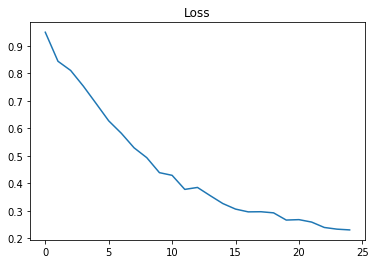

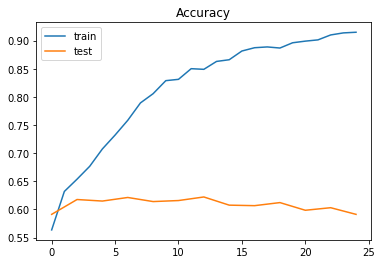

In [6]:
DIM_SIZE = TEXT.vocab.vectors.shape[1]

model = SentimentConv(filter_N=100,kernels=[3,4,5],embedding_dim=DIM_SIZE, outputs=3).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

reshape_target = lambda t : t.view(t.shape[0], 1)

epoch_losses = []
train_accuracys = []
test_accuracys = []
for epoch in range(25):
    if epoch % 2 == 0:
        print(epoch)
    
    train_loss, train_acc = training_epoch(model, 
                                           train_iter, 
                                           nn_embeddings, 
                                           optimizer,
                                           reshape_target = reshape_target)
    train_accuracys.append((epoch, train_acc))
    epoch_losses.append(train_loss)
    
    # Test
    if epoch % 2 == 0:
        test_accuracys.append((epoch, evaluate(model, 
                                               nn_embeddings, 
                                               val_iter, 
                                               reshape_target = reshape_target)))

plot_results(epoch_losses, test_accuracys, train_accuracys)

torch.save(model.state_dict(), MODEL_PATH)

## BINARY CLASSIF

In [23]:
def filter_labels(dataset):
    labels = np.array([ex.label for ex in dataset.examples])
    filtered_label_idx = np.where(np.logical_or(labels == 'positive', labels == 'negative'))[0]
    dataset.examples = [ex for i,ex in enumerate(dataset.examples) if i in filtered_label_idx]
    return dataset

In [232]:
train_bin = filter_labels(train)
val_bin = filter_labels(val)
test_bin = filter_labels(test)

wordemb = torchtext.vocab.GloVe("6B", dim=100, cache=VECTORS_DIR)
# Build the vocabularies
# for labels, we use special_first to False so <unk> is last
# (to discard it)
TEXT.build_vocab(train_bin, vectors=wordemb)
LABEL.build_vocab(train_bin, specials_first=False)
train_bin_iter, val_bin_iter, test_bin_iter = data.BucketIterator.splits(
(train_bin, val_bin, test_bin), batch_size=10, device=device)

0
2
4
6
8
10
12
14
16
18


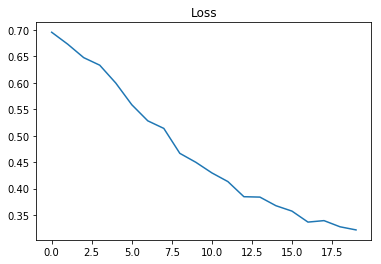

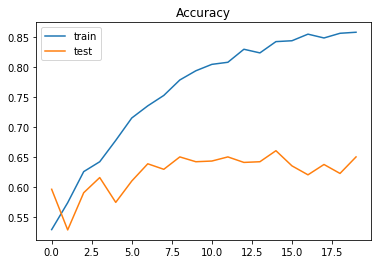

In [98]:
model = SentimentConv(filter_N=20,kernels=[2,3,4,5], outputs=1).to(device=device)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_losses = []
train_accuracys = []
test_accuracys = []
for epoch in range(20):
    if epoch % 2 == 0:
        print(epoch)
    
    train_loss, train_acc = training_epoch(train_bin_iter, model, optimizer, reshape_target=True)
    train_accuracys.append((epoch, train_acc))
    epoch_losses.append(train_loss)
    
    # Test
    if epoch % 1 == 0:
        test_accuracys.append((epoch, evaluate(model, val_bin_iter)))

plot_results(epoch_losses, test_accuracys, train_accuracys)

## Sequential model

In [309]:
class SqueezeConv(nn.Module):
    def forward(self, input):
        return input.squeeze(3)
    
class UnsqueezeConv(nn.Module):
    def forward(self, input):
        return input.unsqueeze(1)

class SeqSentimentConv(nn.Module):
    """
    """

    def __init__(self, 
                 filters_n=[64, 8], 
                 kernels_sizes = [3, 3], 
                 dropout_ratio=0.5, 
                 embedding_dim = 100, 
                 outputs=2):
        super().__init__()
        
        modules = [nn.Conv2d(in_channels=1,
                             out_channels=filters_n[0],
                             kernel_size=(kernels_sizes[0], embedding_dim))]
        modules.append(nn.ReLU())
        modules.append(SqueezeConv())
        modules.append(nn.MaxPool1d(2, stride=2))
        
        modules.append(UnsqueezeConv())
        modules.append(nn.Conv2d(in_channels=1,
                             out_channels=filters_n[1],
                             kernel_size=(kernels_sizes[1], 1394)))
        modules.append(nn.ReLU())
        modules.append(SqueezeConv())
        modules.append(nn.MaxPool1d(2, stride=2))
        
        #for i in range(1, len(filters_n) - 1):
        #    modules.append()
        self.seq_conv = nn.Sequential(*modules)
        
        #self.convs = nn.ModuleList(
        #    [nn.Conv2d(in_channels=1,out_channels=filter_N,kernel_size=(k, embedding_dim)) for k in kernels]
        #)
        self.dropout = nn.Dropout(dropout_ratio)
        self.classifier = nn.Sequential(
            nn.Linear(248, outputs)
        )

    def forward(self, input):
        batch_size = input.shape[0]
        #conveds = [torch.relu(conv(input.unsqueeze(1)).squeeze(3)) for conv in self.convs]
        #pooleds = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conveds]
        output = self.seq_conv(input.unsqueeze(1))
        #import pdb; pdb.set_trace()
        
        output = output.view(batch_size, -1)
        output = self.dropout(output)
        output = self.classifier(output) # on calcule la sortie des fc
        return output

50
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28


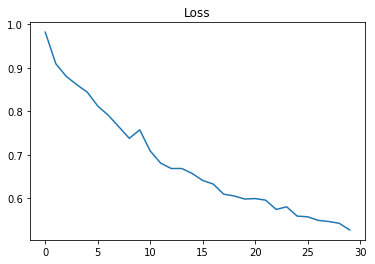

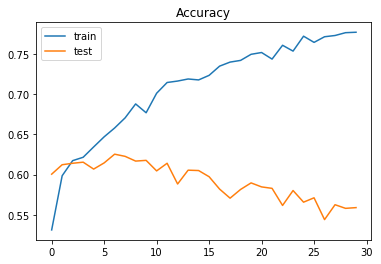

In [286]:
DIM_SIZE = TEXT.vocab.vectors.shape[1]
print(DIM_SIZE)
model = SeqSentimentConv(embedding_dim=DIM_SIZE, outputs=3).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_losses = []
train_accuracys = []
test_accuracys = []
for epoch in range(30):
    if epoch % 2 == 0:
        print(epoch)
    #model,train_iter,embeds, optimizer, reshape_target = False, pad_size=52
    train_loss, train_acc = training_epoch(model, train_iter, nn_embeddings, optimizer)
    train_accuracys.append((epoch, train_acc))
    epoch_losses.append(train_loss)
    
    # Test
    if epoch % 1 == 0:
        test_accuracys.append((epoch, evaluate(model, nn_embeddings,test_iter)))

plot_results(epoch_losses, test_accuracys, train_accuracys)

In [221]:
evaluate(model, test_iter)

0.5660633484162896

## Try different dataset

In [223]:
from torchtext import datasets

In [287]:
wordemb = torchtext.vocab.GloVe("6B", dim=100, cache=VECTORS_DIR)

IMDB_TEXT = data.Field(tokenize='spacy',lower=True,include_lengths=False,batch_first=True)
IMDB_LABEL = data.Field(dtype=torch.float, is_target=True)

train_data, test_data = datasets.IMDB.splits(IMDB_TEXT, IMDB_LABEL)

train_data, valid_data = train_data.split()

IMDB_TEXT.build_vocab(train_data, vectors=wordemb)
IMDB_LABEL.build_vocab(train_data, specials_first=False)

train_iter_imdb, val_iter_imdb, test_iter_imdb = data.BucketIterator.splits(
(train_data, valid_data, test_data), batch_size=20, device=device)

nn_embeddings_imdb = nn.Embedding.from_pretrained(IMDB_TEXT.vocab.vectors).to(device=device)

100
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28


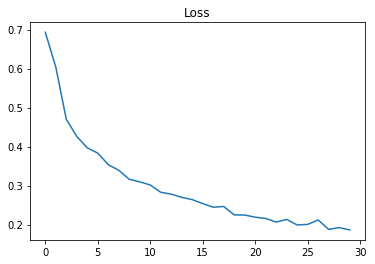

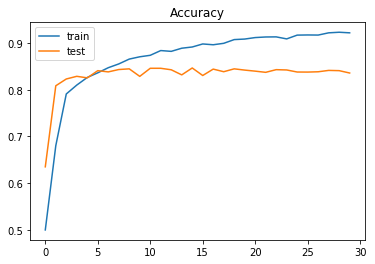

In [351]:
DIM_SIZE = IMDB_TEXT.vocab.vectors.shape[1]
PAD_SIZE = 2790
print(DIM_SIZE)
model = SeqSentimentConv(embedding_dim=DIM_SIZE, outputs=2).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_losses = []
train_accuracys = []
test_accuracys = []
for epoch in range(30):
    if epoch % 2 == 0:
        print(epoch)
    
    train_loss, train_acc = training_epoch(model,train_iter_imdb, nn_embeddings_imdb, optimizer, pad_size=PAD_SIZE)
    train_accuracys.append((epoch, train_acc))
    epoch_losses.append(train_loss)
    
    # Test
    if epoch % 1 == 0:
        test_accuracys.append((epoch, evaluate(model, nn_embeddings_imdb,val_iter_imdb, pad_size=PAD_SIZE)))

plot_results(epoch_losses, test_accuracys, train_accuracys)

# Evaluation qualitative
Ici on va se concantrer au SentimentConv. On cherche

- Analyse du filtres
    --> quelle phrases sont interessantes
- classif
    a. gradient par rapport de chaque sortie
    --> entree qui fait plus varier le reseaux
    --> quel partie du phrase
- Quel est le partie du phrase, qui fait allumer un filtre
    --> comme RDFIA pixels avant

In [94]:
embeds = nn_embeddings
with torch.no_grad():
    all_texts = []
    word_idx = []
    Y = []
    Y_pred = []
    for x,y in test_iter:
        nx = add_padding(x, pad_size=56).cpu().numpy()
        word_idx.append(nx)
        texts = [[TEXT.vocab.itos[i] for i in nx[j,:]] for j in range(nx.shape[0])]
        all_texts.append(texts)
        transformed_text = embeds(add_padding(x))
        output = model(transformed_text)
        Y.append(y)
        Y_pred.append(output.argmax(1).cpu().numpy())

In [118]:
from collections import Counter

data = pd.DataFrame(np.concatenate(all_texts))
word_indexes = pd.DataFrame(np.concatenate(word_idx))
data["Y"] = np.concatenate(Y)
data["Y_pred"] = np.concatenate(Y_pred)

pred_neg = data[data.Y_pred == 2]
pred_pos = data[data.Y_pred == 0]
pred_ntr = data[data.Y_pred == 1]

words_set = set()
words_by_cls = {}
for i, cls in enumerate(['pos', 'ntr','neg']):
    top_words = np.array(Counter(data[data.Y_pred == i].values.flatten()).most_common(200))[:,0]
    words_by_cls[cls] = top_words
    words_set.update(top_words)
    print(top_words[:10])
print(len(words_set))

['<unk>' '0' '.' ',' 'the' 'and' 'a' 'of' 'to' "'s"]
['<unk>' '1' '.' 'the' ',' 'a' 'of' 'and' 'to' 'is']
['<unk>' '2' '.' ',' 'the' 'a' 'to' '1' 'of' "'s"]
288


It is quite complicated to see some differences from the top words of each class. Let's visualize their embeddings.

In [106]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [136]:
embeddings_numpy = nn_embeddings.weight.cpu().numpy()
word2idx = dict(zip(TEXT.vocab.itos, np.arange(len(TEXT.vocab.itos))))
interesting_words = [w for w in list(words_set) if w in word2idx]
interesting_embeddings = embeddings_numpy[[word2idx[w] for w in interesting_words], :]
word2subset_idx = dict(zip(interesting_words, np.arange(len(interesting_words))))
pca = PCA(n_components=30)
tsne = TSNE(n_components=2)

pcaX = pca.fit_transform(interesting_embeddings)
tsneX = tsne.fit_transform(pcaX)

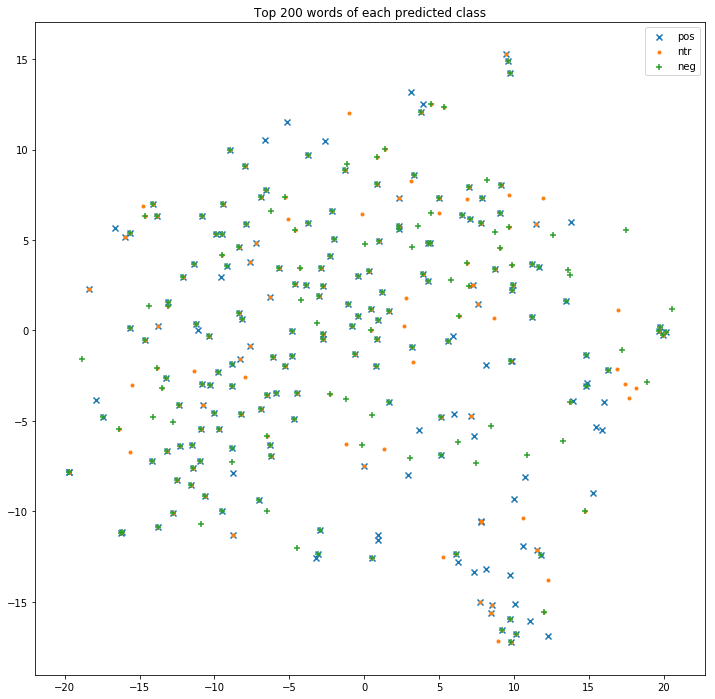

In [151]:
plt.figure(figsize=(12,12))
markers = ['x', '.', '+']
for i, cls in enumerate(['pos', 'ntr','neg']):
    top_words = words_by_cls[cls]
    indexes = [word2subset_idx[w] for w in top_words if w in interesting_words]
    
    plt.scatter(tsneX[indexes,0],tsneX[indexes,1], marker=markers[i], label=cls)
plt.title("Top 200 words of each predicted class")
plt.legend()

#### It is now clear, that our model does not separate classes by the most frequents individual words
As we see in previous plot, the most frequents individual words are quite mixed between classes. Our CNN model considers allways a window of multiple words at once, so let's analyze now the filters.

## Filters

In [159]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

convs.0.weight
convs.0.bias
convs.1.weight
convs.1.bias
convs.2.weight
convs.2.bias
classifier.0.weight
classifier.0.bias


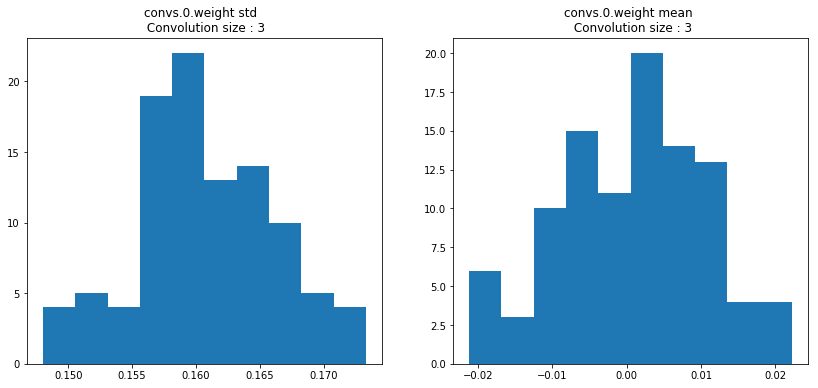

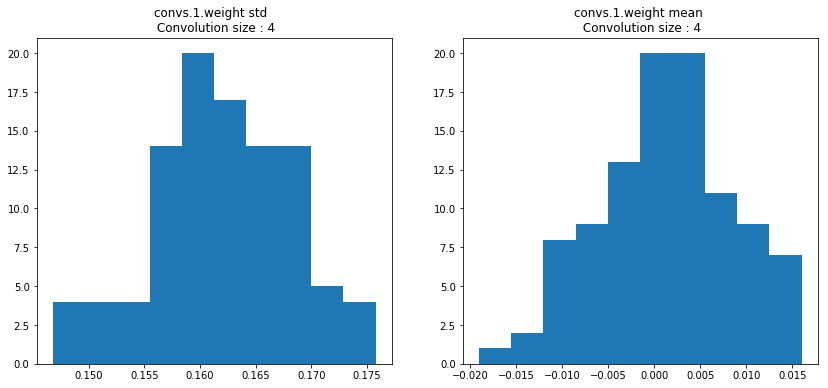

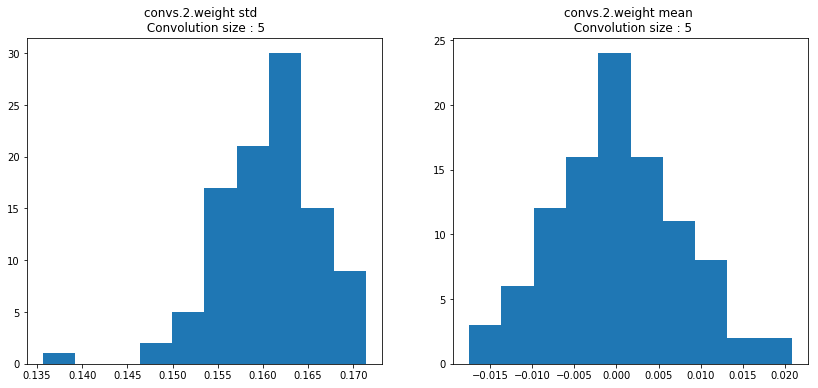

In [184]:
filter_sizes = [3,4,5]
for j, layer in enumerate(['convs.0.weight','convs.1.weight','convs.2.weight']):
    filter_std = np.zeros(100)
    filter_mean = np.zeros(100)
    for i in range(100):
        filt = model.state_dict()[layer][i]
        filter_std[i] = filt.std()
        filter_mean[i] = filt.mean()
    
    layer_explication = " \n Convolution size : {}".format(filter_sizes[j])
    f = plt.figure(figsize=(14,6))
    ax = f.add_subplot(121)
    ax.set_title(layer + " std " + layer_explication)
    ax.hist(filter_std)
    
    ax = f.add_subplot(122)
    ax.set_title(layer + " mean" + layer_explication)
    ax.hist(filter_mean)

It looks like the filters of size 5 are little bit more regular tha ones with size 3. Filters are a bit difficult to interpret. Let's look the gradiants next.

## Gradients

In [35]:
DIM_SIZE = TEXT.vocab.vectors.shape[1]
model = SentimentConv(filter_N=100,kernels=[3,4,5],embedding_dim=DIM_SIZE, outputs=3).to(device=device)
model.load_state_dict(torch.load(MODEL_PATH))
#model.eval()

weight_names = list(model.state_dict().keys())
print(weight_names)

criterion = nn.CrossEntropyLoss()
batches = 0

max_grads = []
var_grads = []
abssum_grads = []
text_lengths = []

all_texts = []
preds = []
labels = []

for batch_i, (x,y) in enumerate(test_iter):
    labels.append(y)
    text_lengths.append(x.shape[1])
    nx = add_padding(x, pad_size=56)
    texts = [[TEXT.vocab.itos[i] for i in nx[j,:].cpu().numpy()] for j in range(nx.shape[0])]
    all_texts.append(texts)
    output = model(nn_embeddings(nx))
    preds.append(output.argmax(1))
    
    loss = criterion(output, y)
    loss.backward()

    grads = [param.grad.data.max().cpu().numpy() for param in model.parameters() if param.requires_grad]
    grads2 = [param.grad.data.var().cpu().numpy() for param in model.parameters() if param.requires_grad]
    max_grads.append(grads)
    var_grads.append(grads2)
    abssum_grads.append([param.grad.data.abs().sum().cpu().numpy() 
                         for param in model.parameters() if param.requires_grad])

text_data = pd.DataFrame(np.concatenate(all_texts))
text_data['pred'] = np.concatenate(preds)
text_data['labels'] = np.concatenate(labels)
data = pd.DataFrame(np.array(abssum_grads), columns=weight_names)
data['lengths'] = np.array(text_lengths)
conv_colums = ['convs.0.weight','convs.1.weight','convs.2.weight']

['convs.0.weight', 'convs.0.bias', 'convs.1.weight', 'convs.1.bias', 'convs.2.weight', 'convs.2.bias', 'classifier.0.weight', 'classifier.0.bias']


Text(0,0.5,'Abs sum of gradient')

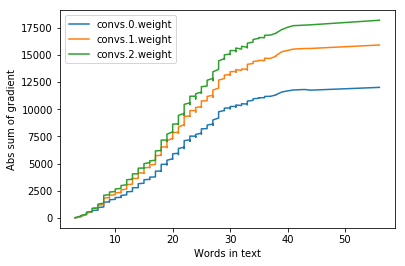

In [71]:
data.plot(y=conv_colums, x='lengths')
plt.xlabel('Words in text')
plt.ylabel('Abs sum of gradient')

In the previous graph we have the sum of gradients of each batch, compared to the length of the texts in that batch. We can see (obviously) that the longer texts have bigger gradients.

Let's concentrate to a subset of batches with text length 8.

In [113]:
data_subset = data[conv_colums + ['lengths']][data.lengths == 8]
indexes = np.array(list(data_subset.index)) * 10
data_subset

,convs.0.weight,convs.1.weight,convs.2.weight,lengths
19,1045.928589,1286.129028,1470.684814,8
20,1051.420776,1303.376709,1487.299683,8
21,1069.985596,1332.104492,1572.531494,8
22,1128.978027,1391.276489,1636.593140,8
23,1147.311401,1411.990234,1676.405029,8
24,1257.989868,1538.891724,1823.558472,8
25,1327.674316,1613.264893,1870.574341,8
26,1400.848022,1726.240723,2001.581177,8
27,1457.337646,1761.197510,2050.529785,8
28,1547.322754,1891.511841,2194.479248,8


We can see that for exemple, the sum of gradients of batch 20 are much more smaller, than the ones of the batch 28. How does these two batches look like? 

In [123]:
text_data[indexes[1]:indexes[2]][text_data.columns.drop(range(8,56))]

,0,1,2,3,4,5,6,7,pred,labels
200,something,the,true,film,buff,will,enjoy,.,0,0
201,an,intriguing,and,entertaining,introduction,to,<unk>,.,0,0
202,clever,",",brutal,and,strangely,soulful,movie,.,0,0
203,morton,is,",",as,usual,",",brilliant,.,0,0
204,the,new,guy,does,have,a,heart,.,0,0
205,just,what,makes,us,happy,",",anyway,?,2,2
206,but,you,'ll,definitely,want,the,t-shirt,.,1,2
207,<unk>,<unk>,'s,script,is,a,gem,.,2,0
208,lead,<unk>,testud,and,parmentier,give,superlative,performances,0,0
209,she,must,have,a,very,strong,back,.,0,0


In [122]:
text_data[indexes[-2]:indexes[-1]][text_data.columns.drop(range(8,56))]

,0,1,2,3,4,5,6,7,pred,labels
270,a,harmless,and,mildly,amusing,family,comedy,.,2,0
271,most,of,the,action,setups,are,incoherent,.,1,1
272,bad,beyond,belief,and,ridiculous,beyond,description,.,1,1
273,...,has,virtually,no,script,at,all,...,1,1
274,propelled,not,by,characters,but,by,caricatures,.,1,1
275,you,'ve,seen,them,a,million,times,.,0,1
276,it,'s,a,flashy,",",<unk>,<unk>,.,0,2
277,but,in,2002,",",such,revelations,<unk>,.,0,2
278,madonna,still,ca,n't,act,a,lick,.,0,1
279,<unk>,",",a,second,assassin,shot,kennedy,?,1,1


When looking only the textual information, it is difficult to see, why are these two batches producing different gradients.

The first batch with smaller gradient is making less errors (3 error in classification) than the one with bigger gradient (5 errors).

Studying gradients was interesting, but it is more useful for understanding the learning phase. Our goal is to study the quality of our already learned model.

## Forward activations

In [79]:
activation_sums = []
lengths = []
all_texts = []
def study_convolutions(module, input, output):
    with torch.no_grad():
        activation_sums.append(output[:].sum(dim=1).sum(dim=0).cpu().numpy())

handle = model.convs[0].register_forward_hook(study_convolutions)

for batch_i, (x,y) in enumerate(test_iter):
    lengths.append(x.shape[1])
    nx = add_padding(x, pad_size=56)
    texts = [[TEXT.vocab.itos[i] for i in nx[j,:].cpu().numpy()] for j in range(nx.shape[0])]
    all_texts.append(texts)
    output = model(nn_embeddings(nx))
    y_pred = output.argmax(1)
    
handle.remove()

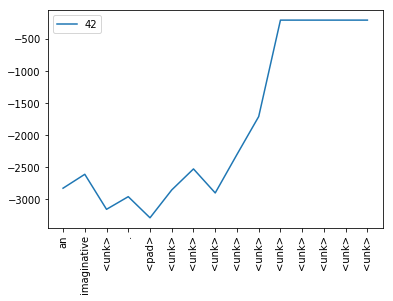

In [80]:
act = np.array(activation_sums)
act = act.reshape(act.shape[0],act.shape[1])
activations = pd.DataFrame(act)
activations['lengths'] = np.array(lengths)
activations[42:43][activations.columns[:15]].transpose().plot()
plt.xticks(np.arange(15),all_texts[3][1], rotation=90);

In [85]:
np.concatenate(all_texts)[43]

array(['disturbing', 'and', 'brilliant', 'documentary', '.', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>'], dtype='<U19')